# Overview of RL fundamentals

## The Q-learning strategy

Our goal is to maximize the discounted, cumulative reward (the return). 

In theory, to maximize return, the correct action must be taken for every different state. To determine which is the correct action, the model needs to estimate the expected return for each action given a state, which is a tricky problem. This value we are trying to estimate is called Q-value, or action value. If we know the action value of every possible action at every possible state, choosing the action with the highest value at every state should give the maximum return (the problem is solved).

#### Temporal difference and discount factor

To actually calculate an action's value, it needs to be compared with the next state-action pair's value. This difference is known as the temporal difference. The different ways in which the next action's value is calculated distinguish different reinforcement learning algorithms. In this case, we use the best possible action in the next state as reference, to try to approximate the best Q function directly. This is based on the Bellman equation. In general, this strategy results in a more efficient algorithm. 

In the end, with Q-learning, the experienced value for an action is the sum of the direct reward for that action and the best possible value for the next state-action pair. To balance the value attributed in the immediate reward with the value attributed to future action values, we use a discount factor $\gamma$. This value ranges from 0 to 1, determining how far-sighted the agent is. The experienced action values are calculated as follows: 

Experienced action value $= r_{t} + \gamma \cdot Q(s_{t+1}, a_{best})$

#### Learning rate

When a model performs an action and receives feedback, it must incorporate this feedback to "learn" from this experience. This means that the known action values must be updated to match this experience. However, simply setting the known value for that action to the experienced value in this instance would create an unstable model, as unknown probabilities can influence the result. Instead, the value that resulted from the action taken is compared to the currently known action value, and the known value for that action is moved towards the experienced value by a learning rate (lr). Higher learning rates should mean faster convergence, but can also cause imprecision and instability.

New value $=$ Previous estimate $+$ lr $\cdot ($ Experienced value - Previous estimate $)$

#### Exploration vs exploitation

For an RL model to learn, it must experience the environment. So, training involves realizing the actions and receiving feedback from them. While the model is training, it selects its actions based on its state, and the currently known action values of the actions in that state. So, as previously mentioned, choosing the action with the highest action value should bring the best result. However, the action values are always just estimates, which means there is a chance that an unknown set of actions can lead to an unexpectedly high return. So, to learn the true best action values, it is necessary to explore alternatives instead of sticking to the currently known best action. 

So, when selecting an action, there is a probability that the action is selected randomly instead of based on action values. This probability is called epsilon. In theory, epsilon should be high when training begins, but should be gradually lowered as the model learns more about the environment, and the known action values are more likely to be accurate. Choosing a random action is known as exploration, while choosing the known best action is known as exploitation. Too much exploitation and the model will not learn enough about the environment, while too much exploration can cause the model to waste time and not converge in a reasonable amount of time.

#### Summary

1. The agent begins picking actions at random, assuming equal value to every action.
2. The model estimates an action's value through both its reward and the value of the best known next action.
3. The corresponding action's value gets updated to reflect this estimated value according to a learning rate.
4. The agent now sometimes takes the best possible action and sometimes explores, according to the exploration factor epsilon.
5. Over time, the difference between an action's known value and its estimated value decreases, as does epsilon, resulting in convergence.



### Implementation of neural networks to form deep Q networks

For continuous observations, we can no longer store an action value for each possible action at each possible state, since there are infinite states. Instead, we create a neural network that maps the observation (the information that describes the state) to a set of the action values of that state. 

- Neural networks can have varying numbers of layers and neurons.
- More layers and neurons can help fit more complex relationships but result in lower efficiency and the possibility of over-fitting.


### Required dependencies for RL example

In [12]:
%pip install matplotlib
%pip install torch
%pip install numpy
%pip install gymnasium
%pip install pygame

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:


# For general use
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

# For neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For environment generation
import gymnasium as gym



#### Select environment and set up variables

In [ ]:
# Select cartpole environment
env = gym.make("CartPole-v1")
# env = gym.make("CartPole-v1",render_mode="human")


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Check if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(device)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

cpu


#### Setup transition storage for the agent's memory

This memory can be sampled randomly, which should stabilize training.

In [15]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Creating neural network class for deep Q-learning
This is based on pytorch's generic neural network module, which uses some key functions:

- nn.Linear(): applies a linear transform using stored weights and biases
- F.relu(): applies a non-linear transform, allowing the neural network to predict non-linear behaviours (Note: other non-linear transforms can be used)
- self.layer: the layer of the neural network, essentially the steps that it follow to transform the inputs into outputs

Neural networks are highly flexible, and should be studied on their own, but they are not the topic of this tutorial.

In [16]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Hyperparameters

- Batch size: Number of transitions "in memory" (transitions in replay buffer).
- Gamma: Discount factor.
- Epsilon: The rate of exploration. Starts with a high value and decreases exponentially to help the model converge.
- LR: Learning rate.
- Tau: Update rate for target network.

In [17]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0



### Action selection using epsilon

In [18]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

#### Plotting progress

In [19]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Model improvement step

In [20]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Training loop

KeyboardInterrupt: 

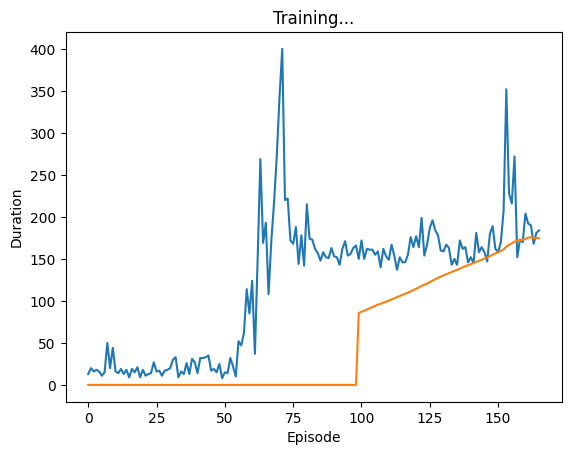

In [21]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 150

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
env.close()